### Data Import


### Using GPT for Information Extraction

The focus of this chapter lies in demonstrating how GPT can be employed in a loop to analyze text documents. This methodology aligns with the principles of topic modeling but extends further by leveraging the advanced capabilities of the language model. Our approach involves the iterative processing of text, where GPT aids in identifying, categorizing, and interpreting the underlying themes and sentiments expressed in social media texts.

The GPT application presents a significant difference compared to traditional topic modeling. While topic modeling often aims to automatically uncover hidden thematic structures within a text corpus, our approach with GPT is based on a different assumption: We presuppose that there is already a specific theme or a particular question in mind according to which we want to organize and analyze the documents. This approach allows us to navigate through the vast amounts of text in social media in a targeted and efficient manner, identifying specific insights and patterns that are directly related to our predefined areas of interest.

The following workflow outlines how we could use this information extraction process to create a topic list. Using the list we can classify each document.

![An example for a GPT based "Topic Modeling" approach. I have used this approach in a current research project, the process is not perfect yet.](https://raw.githubusercontent.com/michaelachmann/social-media-lab/main/images/workflow-topic-modeling.png)


In [50]:
!pip install -q openai backoff gpt-cost-estimator

###  Setup for the OpenAI API
We're using the new Colab Feature to store keys safely within the Colab Environment. Click on the key on the left to add your API key and enable it for this notebook.
Enter the name fpr your API-Key in the `api_key_name` variable below.

In [64]:
import openai
from openai import OpenAI
from google.colab import userdata
import backoff
from gpt_cost_estimator import CostEstimator

api_key_name = "openai-lehrstuhl-api"
api_key = userdata.get(api_key_name)


# Initialize OpenAI using the key
client = OpenAI(
    api_key=api_key
)



@CostEstimator()
def query_openai(model, temperature, messages, mock=True, completion_tokens=10):
    return client.chat.completions.create(
                      model=model,
                      temperature=temperature,
                      messages=messages,
                      max_tokens=600)

# We define the run_request method to wrap it with the @backoff decorator
@backoff.on_exception(backoff.expo, (openai.RateLimitError, openai.APIError))
def run_request(system_prompt, user_prompt, mock):
  messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt}
  ]

  return query_openai(
          model="gpt-3.5-turbo-0613",
          temperature=0.0,
          messages=messages,
          mock=mock
        )

Next, we create a system prompt describing what we want to extract. For further examples of prompts and advice on prompt engineering see e.g. [the prompting guide](https://www.promptingguide.ai/introduction/examples#information-extraction) and further resources linked at the bottom of the page.

For the initial example we use social media content shared by politicans and parties. We know, that some of these texts mention policy issues, let's try to extract these issues across all documents.

**Note:** The extracted issues are not going to be consistent, because each document is sent as a singular request to the API, thus the previous issues are not going to be used as context.

Modify the following system prompt to extract other types of information. What else could you extract?
* Locations (based on names)
* Names (of persons or places)
* Mentions of Companies
* ...

Do not forget the **[Prompt Archive](https://uniregensburg-my.sharepoint.com/:x:/g/personal/acm53421_ads_uni-regensburg_de/EVgX8Avwyx5DvRUGugboTCkBPLxgrndfe6RPfsjGnMs8gA?rtime=jn_wv2zy20g)** when experimenting. Share your successfull prompt with us!

In [19]:
system_prompt = """
You are a helpful assistant, an expert for German politics.
**Objective:** Extract policy issues from German language social media texts. Policy issues refer to specific topics or subjects that are the focus of public or governmental debate, analysis, and decision-making. Elections themselves and party slogans or their performance are no policy issues.
**Instructions:** Return each policy issues referenced in user message as a comma-seperated list. Return 'None' if no policy issues are referenced.
**Formatting:** Return a comma-seperated list.
"""

### Running the request.
The following code snippet uses my [gpt-cost-estimator](https://pypi.org/project/gpt-cost-estimator/) package to simulate API requests and calculate a cost estimate. Please run the estimation whne possible to asses the price-tag before sending requests to OpenAI!
Make sure 'run_request' and 'system_prompt' are defined before this block by running the two blocks above!

Set the following variables:

* `MOCK`: Do you want to mock the OpenAI request (dry run) to calculate the estimated price?
* `RESET_COST`: Do you want to reset the cost estimation when running the query?
* `COLUMN`: What's the column name to save the results of the data extraction task to?
* `SAMPLE_SIZE`: Do you want to run the request on a smaller sample of the whole data? (Useful for testing). Enter 0 to run on the whole dataset.

In [ ]:
from tqdm.auto import tqdm

MOCK = True
RESET_COST = True 
COLUMN = 'Policy Issues'
SAMPLE_SIZE = 0 

# Initializing the empty column
if COLUMN not in new_df.columns:
  new_df[COLUMN] = None

if RESET_COST:
  # Reset Estimates
  CostEstimator.reset()
  print("Reset Cost Estimation")

filtered_df = new_df.copy()

# Skip previously annotated rows
filtered_df = filtered_df[pd.isna(filtered_df['Policy Issues'])]

if SAMPLE_SIZE > 0:
  filtered_df = filtered_df.sample(SAMPLE_SIZE)

for index, row in tqdm(filtered_df.iterrows(), total=len(filtered_df)):
    try:
        response = run_request(system_prompt, row['Text'], MOCK)

        if not MOCK:
          # Extract the response content
          # Adjust the following line according to the structure of the response
          r = response.choices[0].message.content

          # Convert the string 'r' to a list if it's not 'None', otherwise keep it as None
          if r != 'None':
              r = r.split(', ')
          else:
              r = None

          # Update the 'new_df' DataFrame
          new_df.at[index, 'Policy Issues'] = r

    except Exception as e:
        print(f"An error occurred: {e}")
        # Optionally, handle the error (e.g., by logging or by setting a default value)

print()

Reset Cost Estimation


  0%|          | 0/2068 [00:00<?, ?it/s]

In [ ]:
# Save Results
new_df.to_csv('/content/drive/MyDrive/2023-12-01-Export-Posts-Text-Master.csv')

Next we create a `set` of Policy Issues. Sets are similar to lists in that they are used to store multiple items, but each unique item in a set appears only once, regardless of how many times it is added, as sets inherently enforce uniqueness and do not allow duplicates. Unlike lists, sets are unordered, meaning they do not record element position or order of insertion. This property makes sets highly efficient for checking membership and eliminating repeated entries.
We create the list `policy_issues` to generate a word cloud.

In [90]:
unique_policy_issues = set()
policy_issues = []

for issues in new_df['Policy Issues']:
    if issues is not None:
        unique_policy_issues.update(issues)

        for issue in issues:
            policy_issues.append(issue)

print(unique_policy_issues)

{'faires Verfahren', 'Straßen', 'EU-Kommission', 'Zusammenhalt unserer Gesellschaft', 'migrationswende', 'bayernliebe', 'Thema Migration nicht unkontrolliert weiterlaufen lassen', 'Sprache', 'FREIHEITfürBayern', 'Freistaat Bayern', 'rezession', 'Hilfe', 'Mehrwertsteuer', 'tv', 'Lügen', 'Bayern stark und stabil bleibt', 'Baumfreiflächen', 'BAföG-Höchstsatz', 'Online Antrag', 'Zurückweisungen an Binnengrenzen', 'Autoverbot', 'wohnungskonzerne enteignen', 'Infrastrukturausbau', 'Reformierbarkeit des öffentlich-rechtlichen Rundfunks', 'bayerische Antidiskriminierungsstelle', 'Baden-Württemberg', 'Strompreiszonen', 'Streit und Chaos', 'linke Inhalte', 'Soldatenberuf', 'bezahlbare Energie', 'Verkaufszahlen bei Heizungssystemen', 'Forschung und Entwicklung', 'Ölheizungen', 'Situation an den Aussengrenzen', 'Leitungen', 'Verbotsorgien', 'Kriminalität', 'CDU/CSU', 'Sprachen und Kultur', 'deutsche Universität', 'bezahlbares Bayern für alle', 'Souveränität', 'wiedervereinigung', 'Landwirte', 'Rec

Let's quickly generate a wordcloud to check for patterns. See the [Simple Corpus Analysis Notebook](https://github.com/michaelachmann/social-media-lab/blob/main/notebooks/2023_11_24_Simple_Corpus_Analysis.ipynb) for more information.

In [92]:
!pip install -q wordcloud

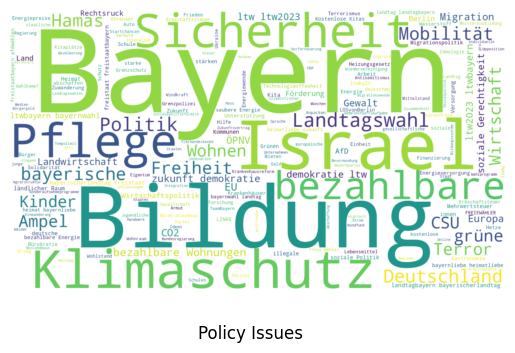

In [99]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import requests

# Retrieve Stopwords from Github
r = requests.get('https://github.com/stopwords-iso/stopwords-de/raw/master/stopwords-de.json')
stop_words = r.json()

# Stopwörter in die WordCloud laden
STOPWORDS.update(stop_words)

def generate_wordcloud(text):
    text = ' '.join(list(text))

    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white",width=1920, height=1080).generate(text)

    # Dazugehörige Grafik erstellen
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.figtext(0.5, 0.1, "Policy Issues", wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

generate_wordcloud(policy_issues)

Now we're ready to pass the list to GPT to extract a manageable amount of topics. **Note** the list might be too long to fit into the GPT context window. In this case we have to split the list into several shorter lists and iterate over them.

This time we are not interested in a specific formatting for the response. We want to print the result for human interpretation.

In [83]:
system_prompt = """
You are a helpful assistant, an expert for German politics. Derive 15 topics of policy issues from this list of keywords provided by the user. Concentrate on overarching topics and avoid overlapping topics. Provide a set of 10 keywords per topic.
"""

In [84]:
keyword_string = ", ".join(unique_policy_issues)
response = run_request(system_prompt, row['Text'], False)

In [85]:
print(response.choices[0].message.content)

1. Sicherheit
- Polizei
- Kriminalität
- Terrorismus
- Überwachung
- Grenzkontrollen

2. Wirtschaftswachstum
- Industrie
- Arbeitsplätze
- Investitionen
- Innovation
- Export

3. Arbeitslosenquote
- Arbeitsmarkt
- Arbeitslosengeld
- Arbeitsvermittlung
- Qualifikationen
- Arbeitslosenversicherung

4. Regierung
- Politik
- Parteien
- Regierungsbildung
- Koalitionen
- Opposition

5. Bayern-Power
- Regionalpolitik
- Infrastruktur
- Bildung
- Kultur
- Tourismus

6. Ampel-Frust
- Politikverdrossenheit
- Koalitionsstreitigkeiten
- Stillstand
- Kompromisse
- Unzufriedenheit

7. Familiengeld
- Familienpolitik
- Kinderbetreuung
- Elternzeit
- Kindergeld
- Unterstützung

8. Pflegegeld
- Pflegepolitik
- Altenpflege
- Pflegeversicherung
- Pflegeheim
- Angehörigenpflege

9. Meisterausbildung
- Berufsausbildung
- Fachkräftemangel
- Handwerk
- Aufstiegschancen
- Weiterbildung

10. Briefwahl
- Wahlrecht
- Wahlbeteiligung
- Demokratie
- Wahlkampf
- Stimmabgabe
